**Autor**: &nbsp; Pedro Martín Calzada &nbsp; (pedro.martinc@estudiante.uam.es)

# Curva de potencia mediante regresión con GPs

El objetivo de este notebook es modelar la curva de potencia de un aerogenerador. La estrategia consiste en entrenar un proceso gaussiano para cada kernel utilizando los datos del año 2020 como conjunto de entrenamiento, y evaluar su desempeño en validación con los datos de 2021. Se escogerá aquel kernel que presente el menor error absoluto medio (MAE).

## Datos Kerlmarsh Nº6 (2020-2021)

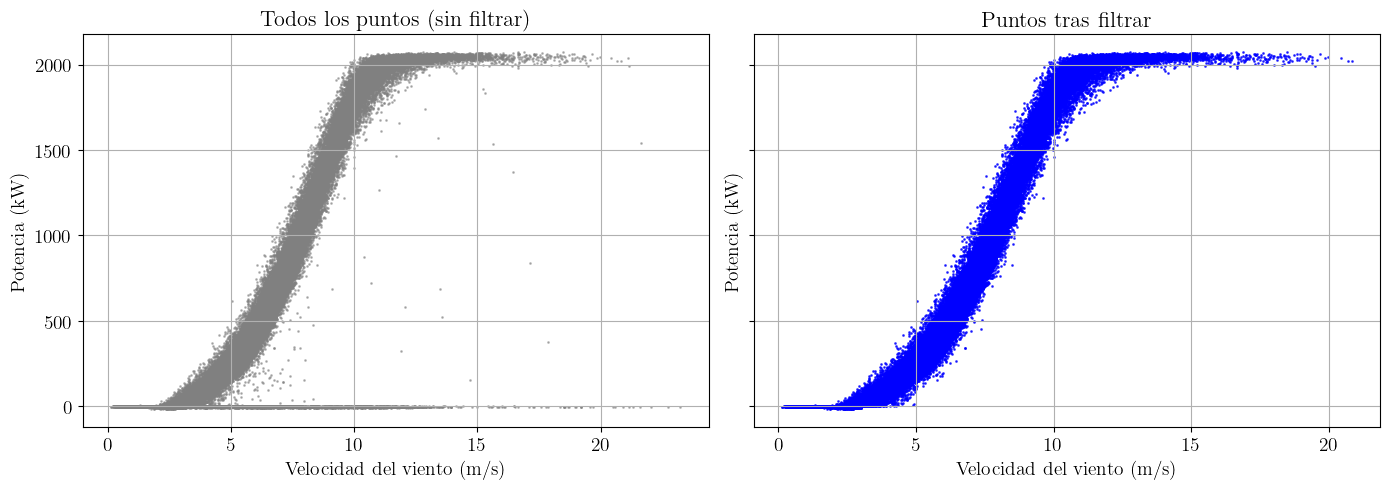

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gráficas con texto en Latex.
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Se importan los datos de 2020 y 2021 de sus respectivos CSV y se unen/concatenan para formar un df único.
df_2020 = pd.read_csv("data_2020.csv")
df_2021 = pd.read_csv("data_2021.csv")
df = pd.concat([df_2020, df_2021], ignore_index=True)

# Velocidad del viento y potencia activa.
V = df['Wind speed (m/s)']
P = df['Power (kW)']

# Máscara para limpieza o filtrado de datos.
# Muchas de las condiciones están basadas en la eliminación de puntos en rectángulos que se intersecan por lo que son redundantes (hay intersecciones).
# Se ajustan a partir de la visualización de las gráficas.
mask = (
    (P > 0) | (V < 3)          # Eliminación de potencias positivas por encima de la velocidad de arranque.
) & (V <= 21) & ~(             # Se descartan velocidades mayores de 21 m/s.
    ((V > 15) & (P < 1900)) |  # Otras condiciones de filtrado por rectángulos.
    ((V > 12) & (P < 1750)) |
    ((V > 11) & (P < 1700)) |
    ((V > 10) & (P < 1500)) |
    ((V > 7.5) & (P < 700)) |
    ((V > 7) & (P < 400)) |
    ((V > 6) & (P < 250)) |
    ((V > 5.5) & (P < 150)) |
    ((V > 5) & (P < 100))
)

# Se aplica la máscara.
V_filtered = V[mask]
P_filtered = P[mask]

# Gráficas.
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Datos sin filtrar.
axes[0].scatter(V, P, color='gray', s=1, alpha=0.5)
axes[0].set_title("Todos los puntos (sin filtrar)", fontsize=16)
axes[0].set_xlabel("Velocidad del viento (m/s)", fontsize=14)
axes[0].set_ylabel("Potencia (kW)", fontsize=14)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].grid(True)

# Datos filtrados.
axes[1].scatter(V_filtered, P_filtered, color='blue', s=1, alpha=0.7)
axes[1].set_title("Puntos tras filtrar", fontsize=16)
axes[1].set_xlabel("Velocidad del viento (m/s)", fontsize=14)
axes[1].set_ylabel("Potencia (kW)", fontsize=14)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Modelado de la curva de potencia con GPs

In [2]:
import GPy
from sklearn.metrics import mean_absolute_error, r2_score

def run_gp_model_mae(kernel, rated_power=2050.0):
    """
    Entrena y evalúa un modelo de regresión basado en procesos gaussianos dispersos
    (Sparse GP) para modelar la curva de potencia de un aerogenerador.

    El modelo se entrena con un subconjunto de datos de 2020 y se evalúa sobre un subconjunto
    de datos de 2021, ambos filtrados mediante una serie de condiciones empíricas que eliminan 
    valores anómalos o físicamente inconsistentes y outliers.

    Parámetros:
    ----------
    kernel : GPy.kern
        Kernel de GPy ya configurado para el modelo GP.
    rated_power : float, opcional (por defecto = 2050.0, para este dataset)
        Potencia nominal del aerogenerador, usada para normalizar la salida.

    Funcionalidad:
    -------------
    - Normaliza la potencia de salida.
    - Divide los datos en bins para seleccionar los conjuntos de entrenamiento y test.
    - Utiliza los bins para seleccionar puntos de inducción.
    - Entrena un modelo Sparse GP con múltiples reinicios de optimización.
    - Visualiza la curva de potencia estimada y la banda de predicción del 95%.
    - Evalúa el modelo sobre los datos de 2021 calculando:
        * Error absoluto medio (MAE).
        * Coeficiente de determinación (R²).
        * Porcentaje de puntos dentro del intervalo de predicción del 95% (PICP).
    - Imprime los hiperparámetros del kernel ajustado.
    """
    
    # Datos de 2020 (se toman solo velocidad del viento y potencia). Se eliminan resgitros a los que les falte alguna variable (missing values).
    df_2020 = pd.read_csv("data_2020.csv")[['Wind speed (m/s)', 'Power (kW)']].dropna()
    V_2020 = df_2020['Wind speed (m/s)']
    P_2020 = df_2020['Power (kW)']
    
    # Máscara para limpieza o filtrado de datos (misma que antes).
    mask_2020 = (
        (P_2020 > 0) | (V_2020 < 3)
    ) & (V_2020 <= 21) & ~(
        ((V_2020 > 15) & (P_2020 < 1900)) |
        ((V_2020 > 12) & (P_2020 < 1750)) |
        ((V_2020 > 11) & (P_2020 < 1700)) |
        ((V_2020 > 10) & (P_2020 < 1500)) |
        ((V_2020 > 7.5) & (P_2020 < 700)) |
        ((V_2020 > 7) & (P_2020 < 400)) |
        ((V_2020 > 6) & (P_2020 < 250)) |
        ((V_2020 > 5.5) & (P_2020 < 150)) |
        ((V_2020 > 5) & (P_2020 < 100))
    )

    # Se aplica la máscara.
    V_train = V_2020[mask_2020]
    P_train = P_2020[mask_2020]

    # Separación por bins de 0'5 m/s. 
    bin_edges = np.arange(0, V_train.max() + 0.5, 0.5)
    X_list = []
    Y_list = []
    inducing_points = []
    np.random.seed(37)  # Reproducibilidad.

    for i in range(len(bin_edges) - 1):
        bin_mask = (V_train >= bin_edges[i]) & (V_train < bin_edges[i + 1])
        bin_v = V_train[bin_mask].values
        bin_p = P_train[bin_mask].values

        if len(bin_v) > 0:
            # Selección de 20 puntos del conjunto de entrenamiento distribuidos por intervalos (bins) de 0.5 m/s.
            idx_sample = np.random.choice(len(bin_v), size=min(20, len(bin_v)), replace=False)
            X_bin = bin_v[idx_sample].reshape(-1, 1)
            Y_bin = bin_p[idx_sample].reshape(-1, 1)
            X_list.append(X_bin)
            Y_list.append(Y_bin)

            if len(X_bin) >= 1:
                # Selección de 5 puntos de inducción de los 20 de entrenamiento de cada bin.
                idx_inducing = np.random.choice(len(X_bin), size=min(5, len(X_bin)), replace=False)
                inducing = np.hstack((X_bin[idx_inducing], (Y_bin[idx_inducing] / rated_power)))
                inducing_points.append(inducing)

    # Se concatenan los puntos de entrenamiento de todos los bins.
    X = np.vstack(X_list)
    Y = np.vstack(Y_list)

    # Normalización de la potencia.
    Y_norm = Y / rated_power

    # Se separan las entradas (velocidades) y salidas (potencias normalizadas).
    Z = np.vstack(inducing_points)
    X_inducing = Z[:, 0:1]
    Y_inducing = Z[:, 1:2]

    # Z_inducing se usa como posiciones iniciales de los inducing points en el modelo GP.
    Z_inducing = X_inducing.copy()

    # Entrenamiento del modelo (cinco iteraciones).
    model = GPy.models.SparseGPRegression(X, Y_norm, kernel=kernel.copy(), Z=Z_inducing)
    # model.optimize(messages=True)
    model.optimize_restarts(num_restarts=5)

    # Visualización de resultados.
    # 500 puntos equiespaciados para ver la función modelada.
    x_pred = np.linspace(0, X.max(), 500).reshape(-1, 1)
    y_pred_norm, y_var_norm = model.predict(x_pred)
    # Se recupera la escala original.
    y_pred = y_pred_norm * rated_power
    y_std = rated_power * np.sqrt(y_var_norm)

    plt.figure(figsize=(10, 5))
    plt.scatter(V_train, P_train, color='#c0f2c6', s=2, alpha=0.4, label=r'\large Datos filtrados')
    plt.plot(x_pred, y_pred, color='red', lw=2, label=r'\large Curva de potencia')
    plt.fill_between(x_pred[:, 0],
                     (y_pred - 1.96 * y_std)[:, 0],
                     (y_pred + 1.96 * y_std)[:, 0],
                     color='#dd6263', alpha=0.3, label=r'\large Banda de predicción (95\%)')
    plt.scatter(X_inducing, Y_inducing * rated_power, color='#005726', s=2, alpha=0.9, label=r'\large Puntos de inducción')
    plt.title(r"Curva de potencia de Kelmarsh Nº6", fontsize=22)
    plt.xlabel(r"Velocidad del viento (m/s)", fontsize=20)
    plt.ylabel(r"Potencia (kW)", fontsize=20)
    plt.tick_params(axis='both', labelsize=18)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Log-verosimilitud maximizada: {model.log_likelihood().item():.6f}\n")

    # Datos de 2021 (para evaluación). Mismo procedimiento que para 2020.
    df_2021 = pd.read_csv("data_2021.csv")[['Wind speed (m/s)', 'Power (kW)']].dropna()
    V_2021 = df_2021['Wind speed (m/s)']
    P_2021 = df_2021['Power (kW)']

    # Misma máscara.
    mask_2021 = (
        (P_2021 > 0) | (V_2021 < 3)
    ) & (V_2021 <= 21) & ~(
        ((V_2021 > 15) & (P_2021 < 1900)) |
        ((V_2021 > 12) & (P_2021 < 1750)) |
        ((V_2021 > 11) & (P_2021 < 1700)) |
        ((V_2021 > 10) & (P_2021 < 1500)) |
        ((V_2021 > 7.5) & (P_2021 < 700)) |
        ((V_2021 > 7) & (P_2021 < 400)) |
        ((V_2021 > 6) & (P_2021 < 250)) |
        ((V_2021 > 5.5) & (P_2021 < 150)) |
        ((V_2021 > 5) & (P_2021 < 100))
    )

    V_test_all = V_2021[mask_2021]
    P_test_all = P_2021[mask_2021]

    
    bin_edges_test = np.arange(0, V_test_all.max() + 0.5, 0.5)
    V_test_list = []
    P_test_list = []
    np.random.seed(42)

    # Separación por bins de 0'5 m/s. 
    for i in range(len(bin_edges_test) - 1):
        bin_mask = (V_test_all >= bin_edges_test[i]) & (V_test_all < bin_edges_test[i + 1])
        v_bin = V_test_all[bin_mask].values
        p_bin = P_test_all[bin_mask].values

        if len(v_bin) > 0:
            # Selección de 20 puntos del conjunto de prueba distribuidos por intervalos (bins) de 0.5 m/s.
            idx = np.random.choice(len(v_bin), size=min(20, len(v_bin)), replace=False)
            V_bin = v_bin[idx].reshape(-1, 1)
            P_bin = p_bin[idx].reshape(-1, 1)
            V_test_list.append(V_bin)
            P_test_list.append(P_bin)

    V_test = np.vstack(V_test_list)
    P_test = np.vstack(P_test_list)

    y_pred_norm_2021, y_var_norm_2021 = model.predict(V_test)
    # Se recupera la escala original.
    y_pred_2021 = y_pred_norm_2021 * rated_power
    y_std_2021 = rated_power * np.sqrt(y_var_norm_2021)

    # Métricas de evaluación.
    # MAE.
    mae = mean_absolute_error(P_test, y_pred_2021)
    print(f"MAE sobre datos filtrados de 2021: {mae:.6f} kW")

    # R² (coeficiente de determinación).
    r2 = r2_score(P_test, y_pred_2021)
    print(f"R² sobre datos filtrados de 2021: {r2:.6f}")

    # Porcentaje de puntos dentro del intervalo de predicción del 95% (PICP).
    lower_2021 = y_pred_2021 - 1.96 * y_std_2021
    upper_2021 = y_pred_2021 + 1.96 * y_std_2021
    within_pi_2021 = np.logical_and(P_test >= lower_2021, P_test <= upper_2021)
    picp_2021 = 100 * np.mean(within_pi_2021)
    print(f"Porcentaje de puntos dentro del IP 95% (PICP) (2021): {picp_2021:.6f}%")

    # Hiperparámetros.
    print("\nHiperparámetros del kernel:")
    for name, val in zip(model.kern.parameter_names(), model.kern.param_array):
        print(f"{name}: {val:.6f}")

### RBF

Optimization restart 1/5, f = -1549.1132614369271
Optimization restart 2/5, f = -1391.3771161793848
Optimization restart 3/5, f = 823.8840814510187
Optimization restart 4/5, f = 823.8840819790106
Optimization restart 5/5, f = -1549.107627358666


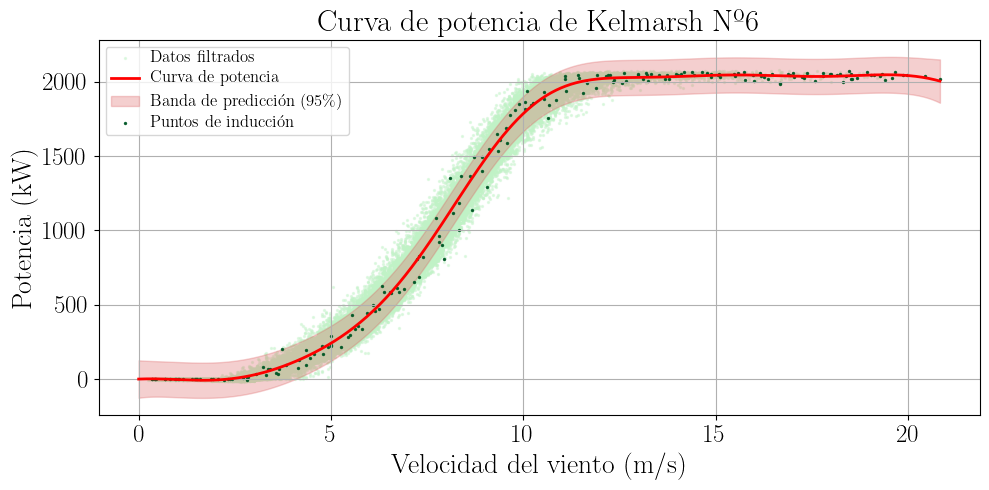

Log-verosimilitud maximizada: 1549.113261

MAE sobre datos filtrados de 2021: 33.113119 kW
R² sobre datos filtrados de 2021: 0.996156
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 94.427711%

Hiperparámetros del kernel:
variance: 0.263475
lengthscale: 3.477651


In [3]:
# Se fija una función kernel. El parámetro que recibe es la dimensión del espacio de entrada (solo velocidad del viento, luego 1 dimensión).
# No es necesario fijar los hiperparámetros porque se seleccionan aleatoriamente en cada una de las cinco iteraciones
# y después se optimizan con un algoritmo (L-BFGS-B, una versión más sofisticada del desceno por el gradiente clásico).
# Se hace lo mismo con cada uno de los 7 kernels restantes.

kernel_rbf = GPy.kern.RBF(1)
run_gp_model_mae(kernel_rbf)

### Racional cuadrático

Optimization restart 1/5, f = -1554.82834785647
Optimization restart 2/5, f = -1554.8225648318476
Optimization restart 3/5, f = 823.8840862129097
Optimization restart 4/5, f = -1554.8228869660816


 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:774: RuntimeWarning:overflow encountered in square
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:779: RuntimeWarning:overflow encountered in square
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:781: RuntimeWarning:overflow encountered in multiply
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:781: RuntimeWarning:invalid value encountered in multiply
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:786: RuntimeWarning:overflow encountered in square
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:788: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 646.8459088332165


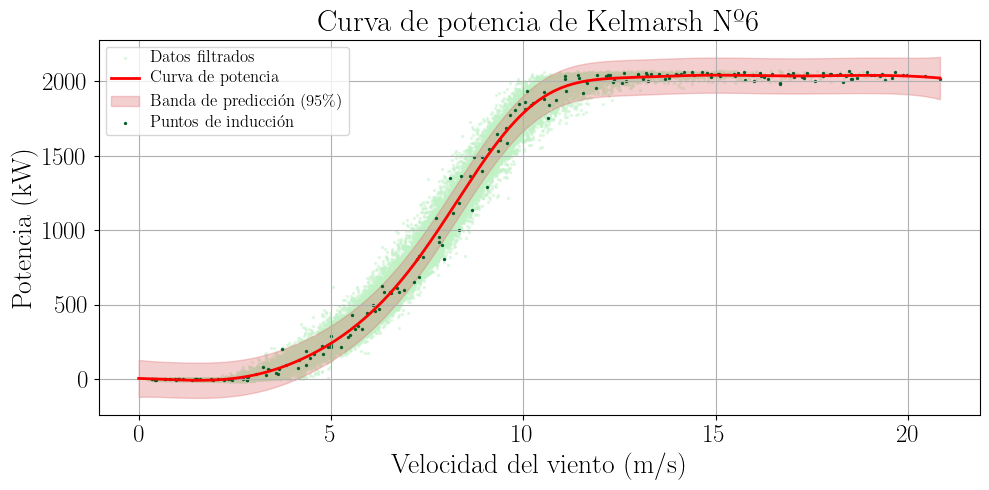

Log-verosimilitud maximizada: 1554.828348

MAE sobre datos filtrados de 2021: 33.078266 kW
R² sobre datos filtrados de 2021: 0.996164
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 94.578313%

Hiperparámetros del kernel:
variance: 0.508222
lengthscale: 4.596971
power: 0.220429


In [4]:
kernel_rq = GPy.kern.RatQuad(1)
run_gp_model_mae(kernel_rq)

### Matérn 3/2

Optimization restart 1/5, f = -1549.4843595031416
Optimization restart 2/5, f = -1547.5931663665688
Optimization restart 3/5, f = 823.8840919966829
Optimization restart 4/5, f = 823.8842160394057
Optimization restart 5/5, f = -1547.7173471113492


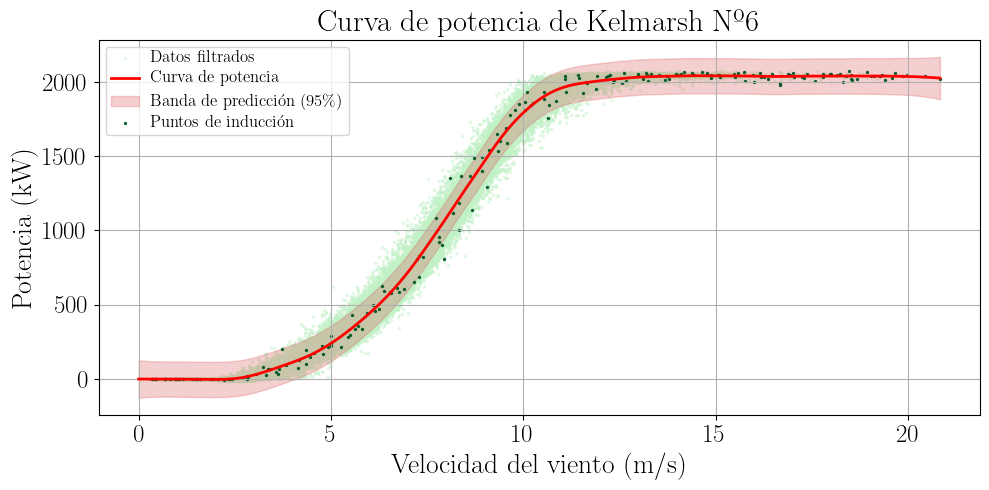

Log-verosimilitud maximizada: 1549.484360

MAE sobre datos filtrados de 2021: 32.818571 kW
R² sobre datos filtrados de 2021: 0.996175
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 95.030120%

Hiperparámetros del kernel:
variance: 0.570468
lengthscale: 21.692200


In [5]:
kernel_m32 = GPy.kern.Matern32(1)
run_gp_model_mae(kernel_m32)

### Matérn 5/2

Optimization restart 1/5, f = -1554.0125405755243
Optimization restart 2/5, f = -1553.4797139417497
Optimization restart 3/5, f = 823.8840878656611
Optimization restart 4/5, f = 823.8840829111499


 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:overflow encountered in square
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:invalid value encountered in multiply
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:overflow encountered in square
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:invalid value encountered in multiply
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:overflow encountered in multiply
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:overflow encountered in multiply
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarni

Optimization restart 5/5, f = -1553.8134177602478


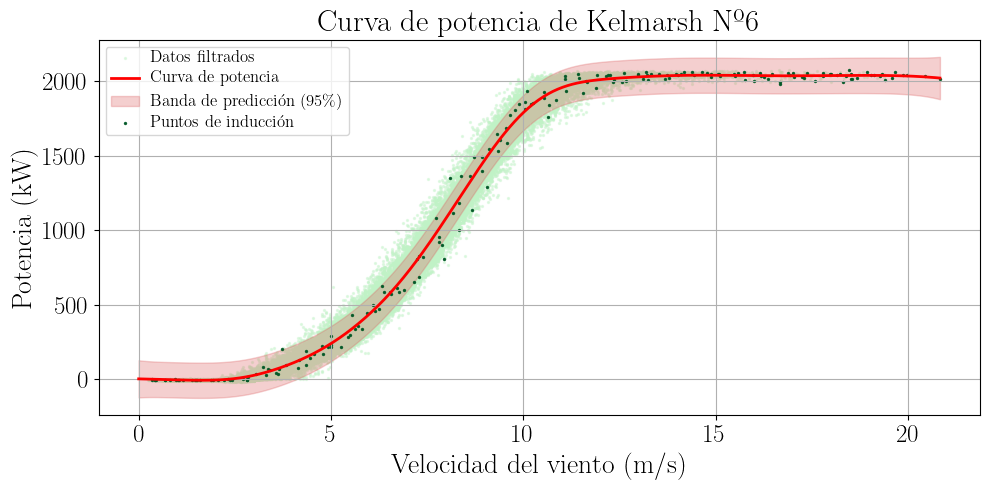

Log-verosimilitud maximizada: 1554.012541

MAE sobre datos filtrados de 2021: 32.969682 kW
R² sobre datos filtrados de 2021: 0.996174
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 95.030120%

Hiperparámetros del kernel:
variance: 0.435370
lengthscale: 10.449042


In [6]:
kernel_m52 = GPy.kern.Matern52(1)
run_gp_model_mae(kernel_m52)

### RBF + Matérn 3/2

Optimization restart 1/5, f = -1553.1792993932322
Optimization restart 2/5, f = -1546.3676016222453
Optimization restart 3/5, f = -1552.9651710068574
Optimization restart 4/5, f = 823.8841371759474


 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:489: RuntimeWarning:overflow encountered in multiply
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:489: RuntimeWarning:invalid value encountered in multiply
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:492: RuntimeWarning:overflow encountered in multiply
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:492: RuntimeWarning:invalid value encountered in multiply
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -1547.8647245293832


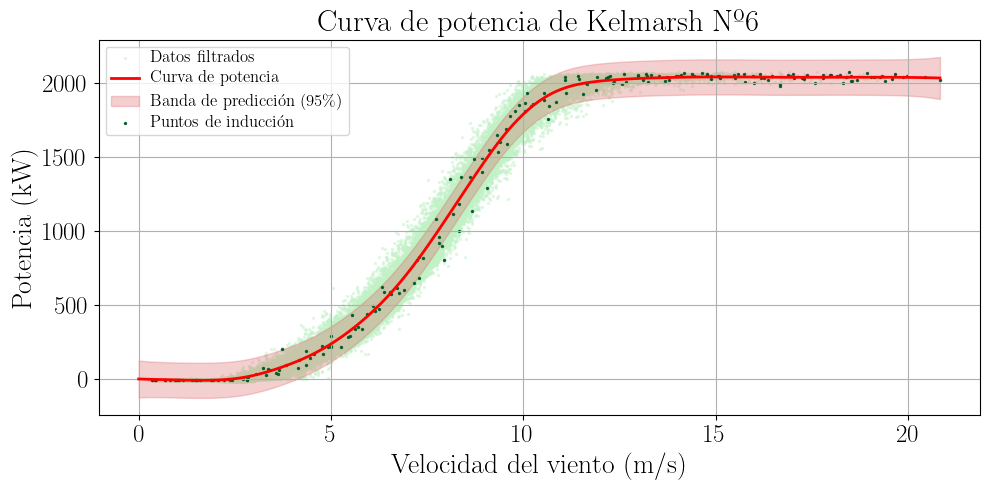

Log-verosimilitud maximizada: 1553.179299

MAE sobre datos filtrados de 2021: 32.973953 kW
R² sobre datos filtrados de 2021: 0.996172
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 94.879518%

Hiperparámetros del kernel:
Mat32.variance: 0.738155
Mat32.lengthscale: 39.847994
rbf.variance: 0.028242
rbf.lengthscale: 3.185538


In [7]:
kernel_rbf_m32 = GPy.kern.Matern32(1) + GPy.kern.RBF(1)
run_gp_model_mae(kernel_rbf_m32)

### Lineal + Racional cuadrático

Optimization restart 1/5, f = -1551.8180434239912
Optimization restart 2/5, f = -1556.0320613971853
Optimization restart 3/5, f = -1514.359382008639
Optimization restart 4/5, f = -1556.0511030330963


 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:774: RuntimeWarning:overflow encountered in square
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:779: RuntimeWarning:overflow encountered in square
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:781: RuntimeWarning:overflow encountered in multiply
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:781: RuntimeWarning:invalid value encountered in multiply
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:786: RuntimeWarning:overflow encountered in square
 /home/pedro/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:788: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -361.27150169299057


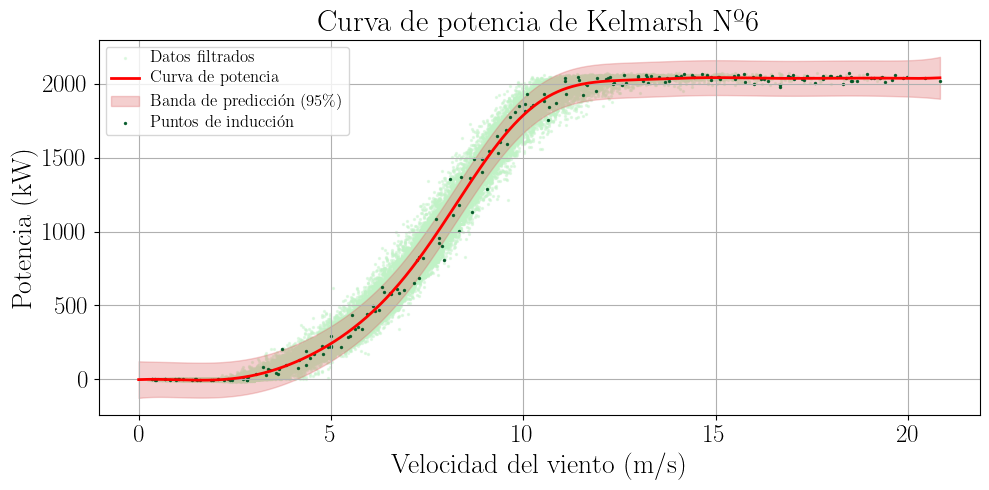

Log-verosimilitud maximizada: 1556.051103

MAE sobre datos filtrados de 2021: 32.948196 kW
R² sobre datos filtrados de 2021: 0.996164
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 94.427711%

Hiperparámetros del kernel:
linear.variances: 0.002585
RatQuad.variance: 0.049900
RatQuad.lengthscale: 6.025761
RatQuad.power: 2.320070


In [8]:
kernel_linear_rq = GPy.kern.Linear(1) + GPy.kern.RatQuad(1)
run_gp_model_mae(kernel_linear_rq)

### Matérn 1/2

Optimization restart 1/5, f = -1488.0521791261563
Optimization restart 2/5, f = -1367.231676176656
Optimization restart 3/5, f = 823.8840814595138
Optimization restart 4/5, f = 823.8840814283266
Optimization restart 5/5, f = -1374.683599966811


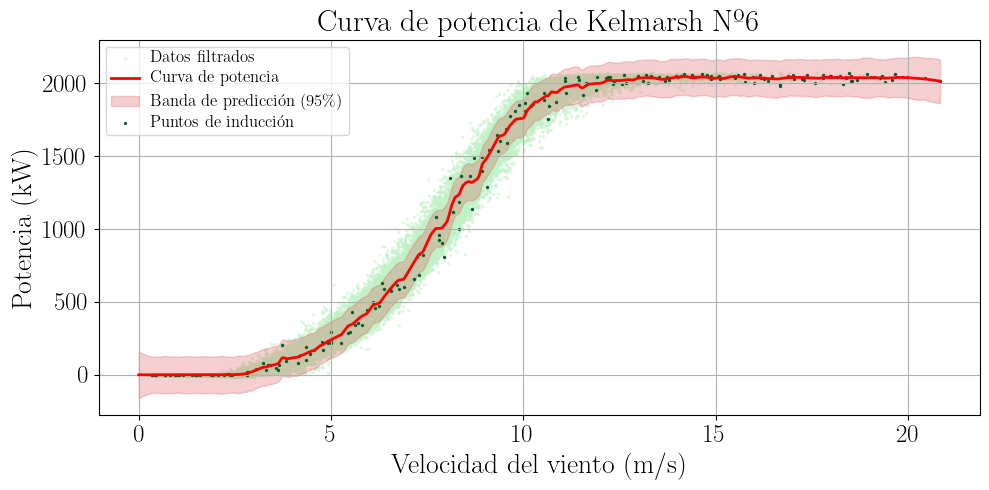

Log-verosimilitud maximizada: 1488.052179

MAE sobre datos filtrados de 2021: 32.894416 kW
R² sobre datos filtrados de 2021: 0.996132
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 95.331325%

Hiperparámetros del kernel:
variance: 0.045130
lengthscale: 40.736121


In [9]:
kernel_m12 = GPy.kern.Exponential(1)
run_gp_model_mae(kernel_m12)

### Periódico

Optimization restart 1/5, f = 422.06678449902415
Optimization restart 2/5, f = 420.328262922101
Optimization restart 3/5, f = 421.0153553582617
Optimization restart 4/5, f = 420.0061320471418
Optimization restart 5/5, f = 421.0920260174164


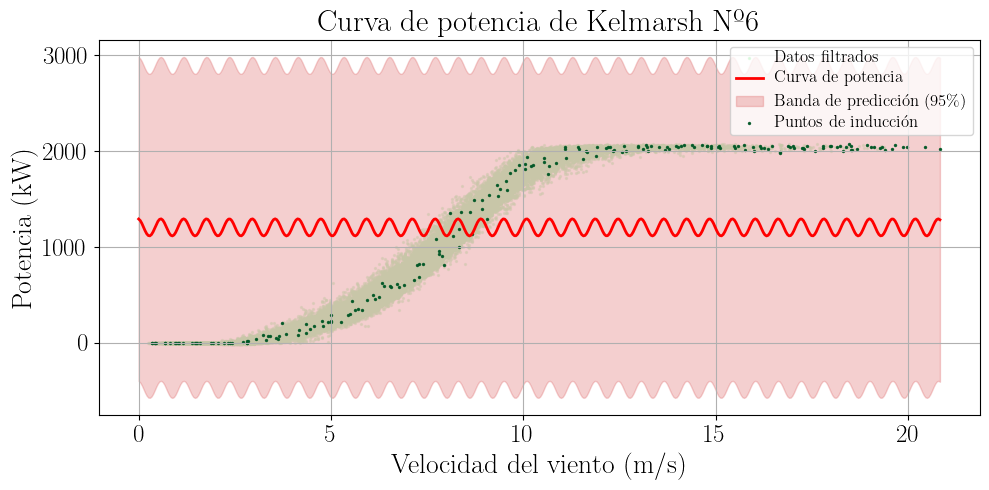

Log-verosimilitud maximizada: -420.006132

MAE sobre datos filtrados de 2021: 807.660766 kW
R² sobre datos filtrados de 2021: -0.020730
Porcentaje de puntos dentro del IP 95% (PICP) (2021): 100.000000%

Hiperparámetros del kernel:
variance: 0.344727
period: 0.594200
lengthscale: 8.139033


In [10]:
kernel_per = GPy.kern.StdPeriodic(1)
run_gp_model_mae(kernel_per)